In [277]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from sparkmetrics import SparkMetric, DataLoader, plot_shuffleIO, plot_heapMemory

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [278]:
data_path = Path("/run/media/berombau/data/thesis/notebooks/metrics")
timezone = 'Europe/Brussels'
dl = DataLoader(data_path, timezone)
df = dl.load_dataset()

df

# df.loc[df["metric" == SparkMetric.cpuTime.value], "value"] /= 1000

,executor,metric,time,value
0,1,executor.cpuTime,2020-11-25 19:38:23+01:00,0.000000e+00
1,1,executor.cpuTime,2020-11-25 19:38:33+01:00,0.000000e+00
2,1,executor.cpuTime,2020-11-25 19:38:43+01:00,3.495282e+03
3,1,executor.cpuTime,2020-11-25 19:38:53+01:00,3.495282e+03
4,1,executor.cpuTime,2020-11-25 19:39:03+01:00,3.495282e+03
...,...,...,...,...
46305,3,ExecutorMetrics.JVMOffHeapMemory,2020-11-25 19:57:25+01:00,9.142658e+07
46306,3,ExecutorMetrics.JVMOffHeapMemory,2020-11-25 19:57:35+01:00,9.148685e+07
46307,3,ExecutorMetrics.JVMOffHeapMemory,2020-11-25 19:57:45+01:00,9.151318e+07
46308,3,ExecutorMetrics.JVMOffHeapMemory,2020-11-25 19:57:55+01:00,9.165686e+07


# Plot of single executor memory

## Stages

- 0
    - repartition
    - Tools.scala:94
    - 3s
- 1
    - count
    - BlsSpeller.scala:159
    - 0.5s
    - create input motifIterator
- 2
    - repartition
    - Tools.scala:94
    - skipped
- 3
    - flatMap
    - Tools.scala:122
    - 22min
    - run motifIterator
- 4
    - runJob
    - SparkHadoopWriter.scala:78
    - 2.7min
    - write output

## Stage 3

Closer look at stage 3 for exector 1

- 23:46
    - Start of task 1 in stage 3 by exectutor
    - iratic onheap execution memory behaviour
    - growing memory of motifIterator to max 800MB
- 00:01
    - unknown event
    - motifIterator is done?
    - flatMap of 
- 00:05
    - end of task 1
    - all memory metrics to 0
    - exectur is idle

%matplotlib inlineStart of Stage 3 (pipe to MotifIterator). Stage 3 end at 23:05

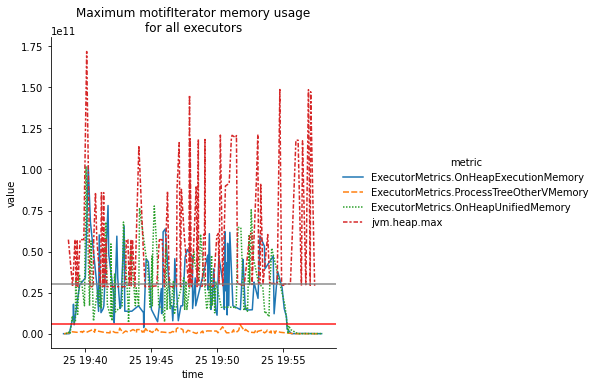

In [292]:
import seaborn as sns
subset_metrics = [
    "ExecutorMetrics.ProcessTreeOtherVMemory",
    "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
    "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
    "jvm.heap.max"
#     "ExecutorMetrics.OffHeapExecutionMemory",
]

df_subset = (df[df["metric"]
                .isin(subset_metrics)]
            .query("executor != 'driver'")
            ).groupby(["metric", "time"]).agg({'value': 'sum'}).reset_index()

df_subset = df_subset.sort_values(by="time")
df_subset = df_subset[::5]

g = sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")
plt.title("Maximum motifIterator memory usage\nfor all executors")
for ax in g.axes.ravel():
    ax.axhline((6 * 1024)*1e6, alpha=0.9, color='red', label="Exectur memory overhead")
    ax.axhline(30e9, alpha=0.9, color='grey', label="Executor total memory")
    handles, _ = ax.get_legend_handles_labels()
#     plt.legend(handles = handles[4:])

Text(0.5, 1.0, 'Maximum motifIterator memory usage\nfor all executors')

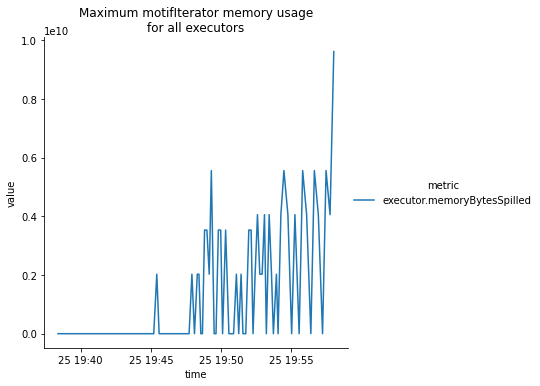

In [320]:
import seaborn as sns
subset_metrics = [
    "executor.memoryBytesSpilled",
]

df_subset = (df[df["metric"]
                .isin(subset_metrics)]
            .query("executor != 'driver'")
            ).groupby(["time", "metric"]).agg({'value': 'sum'})

df_subset = df_subset.sort_values(by="time")
df_subset = df_subset[::5]

g = sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")
plt.title("Maximum motifIterator memory usage\nfor all executors")
# for ax in g.axes.ravel():
#     ax.axhline((6 * 1024)*1e6, alpha=0.9, color='red', label="Exectur memory overhead")
#     ax.axhline(30e9, alpha=0.9, color='grey', label="Executor total memory")
#     handles, _ = ax.get_legend_handles_labels()
#     plt.legend(handles = handles[4:])

In [318]:
df_subset

value
metric                      time                                   
executor.memoryBytesSpilled 2020-11-25 19:38:23+01:00  0.000000e+00
                            2020-11-25 19:38:38+01:00  0.000000e+00
                            2020-11-25 19:38:49+01:00  0.000000e+00
                            2020-11-25 19:38:59+01:00  0.000000e+00
                            2020-11-25 19:39:06+01:00  0.000000e+00
...                                                             ...
                            2020-11-25 19:56:55+01:00  4.055953e+09
                            2020-11-25 19:57:13+01:00  0.000000e+00
                            2020-11-25 19:57:28+01:00  5.559167e+09
                            2020-11-25 19:57:45+01:00  4.055953e+09
                            2020-11-25 19:58:01+01:00  9.615120e+09

[110 rows x 1 columns]

Text(0.5, 1.0, 'Maximum motifIterator memory usage\nfor all executors')

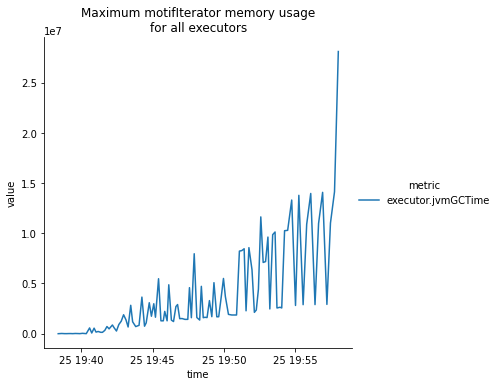

In [307]:
import seaborn as sns
subset_metrics = [
    "executor.jvmGCTime",
]

df_subset = (df[df["metric"]
                .isin(subset_metrics)]
            .query("executor != 'driver'")
            ).groupby(["metric", "time"]).agg({'value': 'sum'}).reset_index()

df_subset = df_subset.sort_values(by="time")
df_subset = df_subset[::5]

g = sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")
plt.title("Maximum motifIterator memory usage\nfor all executors")

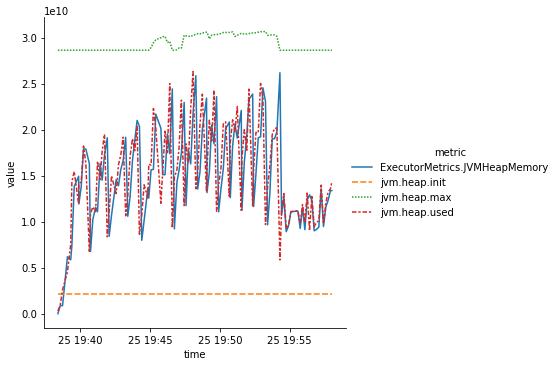

In [280]:
plot_heapMemory(df, executor=2)

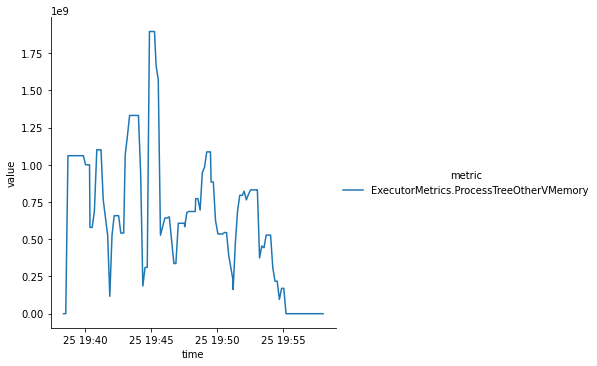

In [281]:
subset_metrics = [
# "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
    "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
#     "ExecutorMetrics.JVMHeapMemory",
#     "ExecutorMetrics.JVMOffHeapMemory",
#     "ExecutorMetrics.MappedPoolMemory",
#     "ExecutorMetrics.DirectPoolMemory",
#     "NettyBlockTransfer.shuffle-server.usedDirectMemory",
#     "executor.memoryBytesSpilled",
#     "executor.diskBytesSpilled",
]

df_subset = (df[df["metric"]
                .isin(subset_metrics)]
            .query("executor == '1'")
            )
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")

In [282]:
df_nd = df.query("executor != 'driver'")

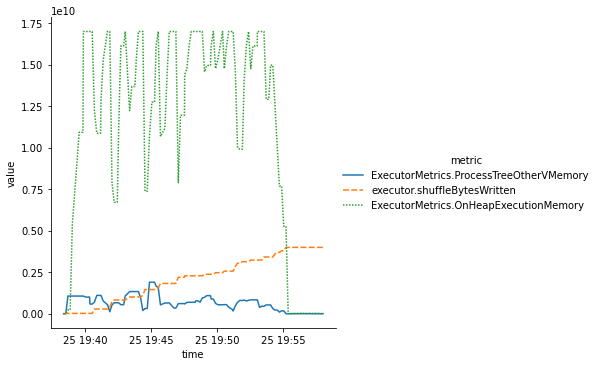

In [283]:
subset_metrics = [
# "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
    "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
    "ExecutorMetrics.OnHeapExecutionMemory",
    "executor.shuffleBytesWritten",
#     "ExecutorMetrics.OffHeapExecutionMemory",
#     "ExecutorMetrics.JVMHeapMemory",
#     "ExecutorMetrics.JVMOffHeapMemory",
#     "ExecutorMetrics.MappedPoolMemory",
#     "ExecutorMetrics.DirectPoolMemory",
#     "NettyBlockTransfer.shuffle-server.usedDirectMemory",
# #     "executor.memoryBytesSpilled",
#     "executor.diskBytesSpilled",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)]
            .query("executor == '1'"))
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")

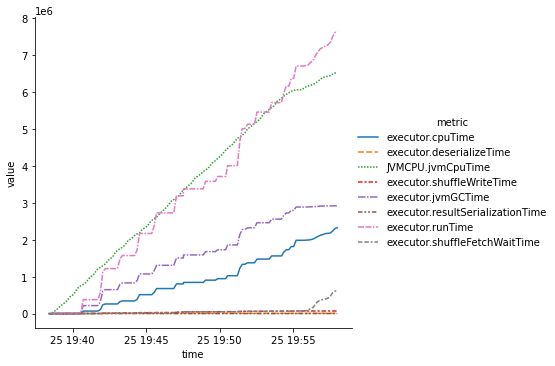

In [329]:
subset_metrics = [x.value for x in [
# "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
#     "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
#     "executor.shuffleBytesWritten",
#     "ExecutorMetrics.OffHeapExecutionMemory",
#     "ExecutorMetrics.JVMHeapMemory",
#     "ExecutorMetrics.JVMOffHeapMemory",
#     "ExecutorMetrics.MappedPoolMemory",
#     "ExecutorMetrics.DirectPoolMemory",
#     "NettyBlockTransfer.shuffle-server.usedDirectMemory",
    SparkMetric.GCTime,
    SparkMetric.deserializeTime,
    SparkMetric.cpuTime,
    SparkMetric.runTime,
    SparkMetric.shuffleWriteTime,
    SparkMetric.shuffleFetchWaitTime,
    SparkMetric.resultSerializationTime,
    SparkMetric.JVMCPUTime,
#     SparkMetric.diskBytesSpilled
#     "executor.threadpool.activeTasks"
]]
            
df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)]
            .query("executor == '1'"))
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")

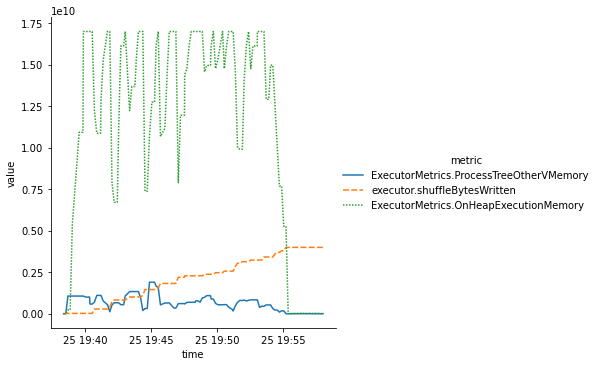

In [285]:
subset_metrics = [
# "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
    "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
    "ExecutorMetrics.OnHeapExecutionMemory",
    "executor.shuffleBytesWritten",
#     "ExecutorMetrics.OffHeapExecutionMemory",
#     "ExecutorMetrics.JVMHeapMemory",
#     "ExecutorMetrics.JVMOffHeapMemory",
#     "ExecutorMetrics.MappedPoolMemory",
#     "ExecutorMetrics.DirectPoolMemory",
#     "NettyBlockTransfer.shuffle-server.usedDirectMemory",
# #     "executor.memoryBytesSpilled",
#     "executor.diskBytesSpilled",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)]
            .query("executor == '1'"))
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="metric", kind="line")

Same erratic OnHeapExecutionMemory behaviour for all execturs.
Ceiling at 2.6GB

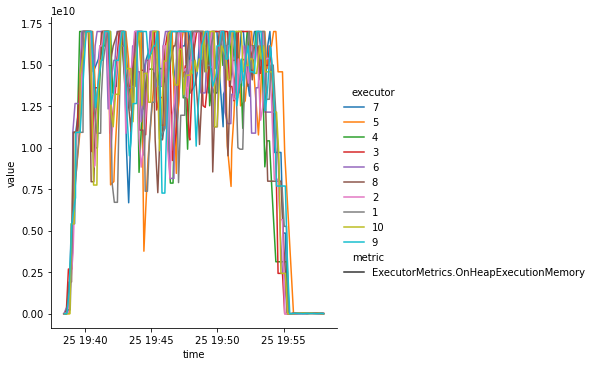

In [286]:
subset_metrics = [
#     "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
#     "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
    "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)])
sns.relplot(data=df_subset, x="time", y="value", style="metric", hue="executor", kind="line")

Task 12 at executor 13 has +4 GB of extra memory for motifIterator then the regular 1 GB. Why?
No other metrics are different, except Shuffle Remote Reads of 5.7 MiB instead of <1MiB

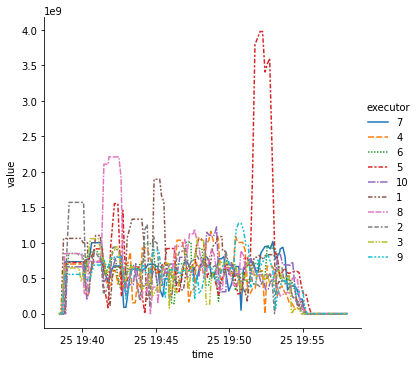

In [287]:
subset_metrics = [
#     "ExecutorMetrics.ProcessTreeJVMVMemory",
#     "ExecutorMetrics.ProcessTreeJVMRSSMemory",
    "ExecutorMetrics.ProcessTreeOtherVMemory",
#     "ExecutorMetrics.ProcessTreeOtherRSSMemCloserory",
#     "ExecutorMetrics.OnHeapUnifiedMemory",
#     "ExecutorMetrics.OffHeapUnifiedMemory",
#     "ExecutorMetrics.OnHeapExecutionMemory",
#     "ExecutorMetrics.OffHeapExecutionMemory",
]

df_subset = (df_nd[df_nd["metric"]
                .isin(subset_metrics)])
sns.relplot(data=df_subset, x="time", y="value", style="executor", hue="executor", kind="line")

In [288]:
df = pd.DataFrame.from_dict(data)
pd.options.display.max_columns = None
df

NameError: name 'data' is not defined

In [ ]:
df["submissionTime"] = pd.to_datetime(df["submissionTime"], unit="ms")
df["completionTime"] = pd.to_datetime(df["completionTime"], unit="ms")
df["executorCpuTime"] = df["executorCpuTime"] / 1000
df["executorDeserializeCpuTime"] = df["executorDeserializeCpuTime"] / 1000
df

In [ ]:
def plot_n_active_tasks(df):
#     colormap = cm.get_cmap('viridis', df["stageId"].max() + 1)
#     colors = df["jobId"].apply(lambda x: colormap.colors[x])
    plot = df.plot.bar(x="submissionTime", y=["numTasks"])
    
def plot_jvm_cpu_usage(df):
    plot = df.plot.bar(x="submissionTime", y=["executorCpuTime"])

def plot_time_components(df):
    components = [
        "executorDeserializeCpuTime", 
        "executorDeserializeTime",
        "executorCpuTime",
        "shuffleWriteTime",
        "resultSerializationTime",
        "shuffleFetchWaitTime",
        "jvmGCTime",
    ]
#     fig, ax = plt.subplots(1, 1)
    ax = df.plot.line(x="submissionTime", y="executorRunTime", use_index=False)
    df.plot.bar(x="submissionTime", y=components, stacked=True, use_index=False, ax=ax)
    
    
def plot_peak_memory(df):
    plot = df.plot.bar(x="submissionTime", y=["peakExecutionMemory"])

In [ ]:
plot_n_active_tasks(df)
plot_jvm_cpu_usage(df)
plot_time_components(df)
plot_peak_memory(df)